In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train = np.load('D:/SIH_Dataset/train_test/X_train.npy')

In [3]:
X_train.max(), X_train.min(), X_train.dtype, X_train.shape

(255, 0, dtype('uint8'), (25912, 256, 256, 4))

In [3]:
y_train = np.load('D:/SIH_Dataset/train_test/y_train.npy')

##Let's plot a sample input RGB image and output image with buildings

9901


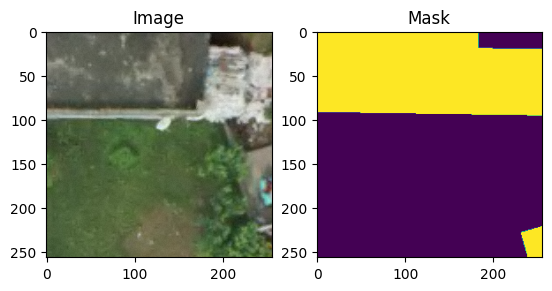

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2)
img = np.random.randint(0, 25912)
print(img)
ax1.imshow(X_train[img, :, :, :3])
ax2.imshow(y_train[img, :, :, 0])
ax1.set_title("Image")
ax2.set_title('Mask')
plt.show()

In [4]:
X_test = np.load('D:/SIH_Dataset/train_test/X_test.npy')

In [5]:
y_test = np.load('D:/SIH_Dataset/train_test/y_test.npy')

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25912, 256, 256, 4),
 (25912, 256, 256, 1),
 (12870, 256, 256, 4),
 (12870, 256, 256, 1))

## U-Net

In [6]:
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [7]:
x_in = Input(shape=(256, 256, 4))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [8]:
!pip install tensorflow==2.12.0

### Training model

In [9]:
import tensorflow as tf

In [11]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("buildings.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks = [
    earlyStopping,
    checkpointer
    ]
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=2,
                    batch_size=8,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/2
3239/3239 [==============================] - 16131s 5s/step - loss: 0.0749 - val_loss: 0.2189

Epoch 1: val_loss improved from inf to 0.21889, saving model to buildings.h5
Epoch 2/2
3239/3239 [==============================] - 15332s 5s/step - loss: 0.0645 - val_loss: 0.1911

Epoch 2: val_loss improved from 0.21889 to 0.19107, saving model to buildings.h5


###plot model loss over training and validation data

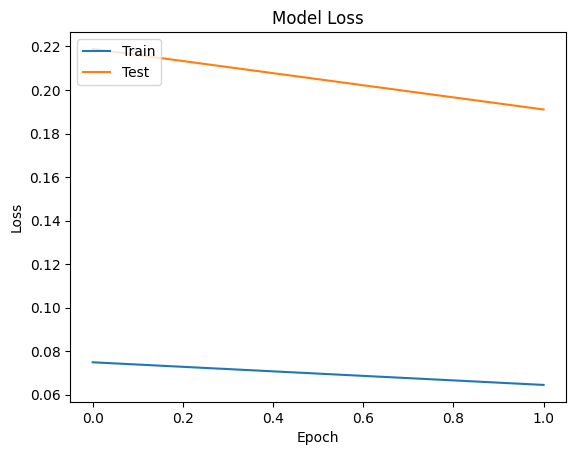

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
from tensorflow.keras.models import load_model

In [34]:
model = load_model('buildings.h5')

### Prediction of the output

In [94]:
pred_test = model.predict(X_test)

403/403 [==============================] - 2163s 5s/step


In [95]:
pred_test.dtype

dtype('float32')

In [96]:
threshold = 0.2
pred_test = (pred_test > threshold).astype(np.uint8)

In [ ]:
loss, accuracy = model.evaluate(y_test, pred_test, verbose=1)

###let's compare random predicted and actual y values

4304


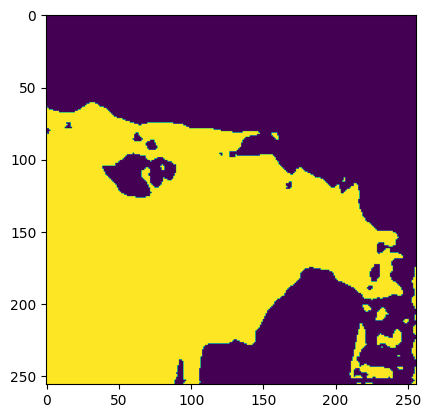

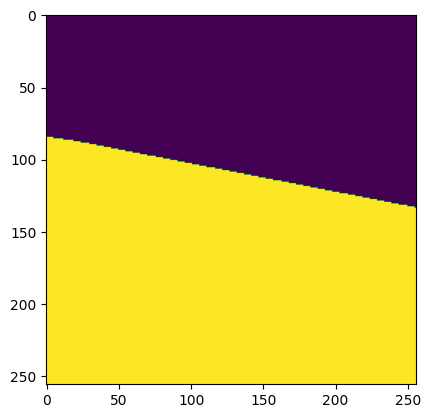

In [97]:
img = np.random.randint(0, 12870)
print(img)
plt.imshow(pred_test[img, :, :, 0])
plt.show()
plt.imshow(y_test[img,:,:,0])
plt.show()

### Accuracy Assessment

In [98]:
y_test = y_test.astype('uint8')
pred_test = pred_test.astype('uint8')

In [99]:
def calculate_metrics(ground_truth, predicted_mask):
    # Flatten the binary masks to 1D arrays
    ground_truth = ground_truth.ravel()
    predicted_mask = predicted_mask.ravel()

    # True Positives, False Positives, False Negatives
    TP = np.sum((ground_truth == 1) & (predicted_mask == 1))
    FP = np.sum((ground_truth == 0) & (predicted_mask == 1))
    FN = np.sum((ground_truth == 1) & (predicted_mask == 0))

    # True Negatives (may not be needed)
    TN = np.sum((ground_truth == 0) & (predicted_mask == 0))

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate Intersection over Union (IoU)
    iou = TP / (TP + FP + FN)

    return precision, recall, f1_score, iou

In [100]:
print(calculate_metrics(y_test, pred_test))

(0.6028622098626418, 0.9153696180238949, 0.726953210474058, 0.5710341650087828)
